In [1]:
!pip install tensorflow opencv-python matplotlib transformers

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunjshah01","key":"ecf5c72482ced9a69e68c16802c17623"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download the data from the Kaggle
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces
!unzip -q 140k-real-and-fake-faces.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [00:34<00:00, 136MB/s]
100% 3.75G/3.75G [00:34<00:00, 117MB/s]


In [7]:
#Deal with the data
base_path = "/content/data/real_vs_fake/real-vs-fake/"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
valid_path = os.path.join(base_path, "valid")

In [8]:
print("Training real images: ", len(os.listdir(os.path.join(train_path, "real"))))
print("Training fake images: ", len(os.listdir(os.path.join(train_path, "fake"))))
print("Testing real images: ", len(os.listdir(os.path.join(test_path, "real"))))
print("Testing fake images: ", len(os.listdir(os.path.join(test_path, "fake"))))

Training real images:  50000
Training fake images:  50000
Testing real images:  10000
Testing fake images:  10000


In [9]:
#Selection of pre-trained model for deep fake detection
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
#Building the model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid'),

])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [12]:
valid_gen = datagen.flow_from_directory(
    valid_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.


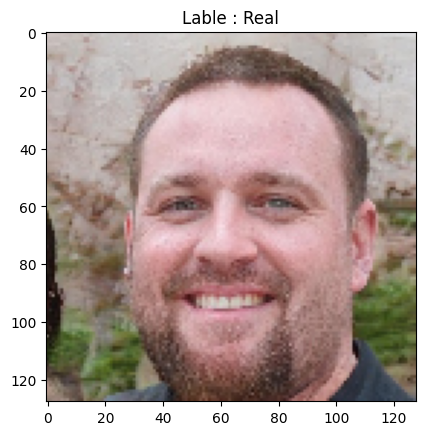

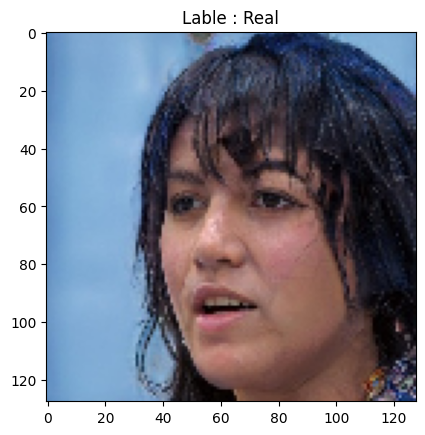

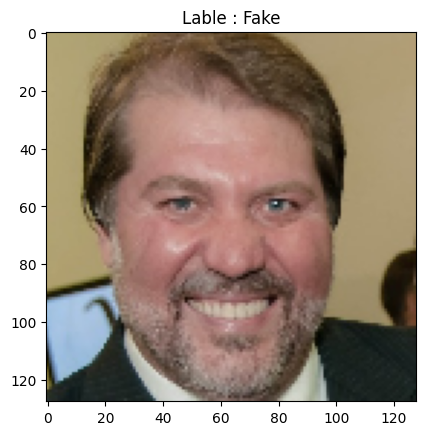

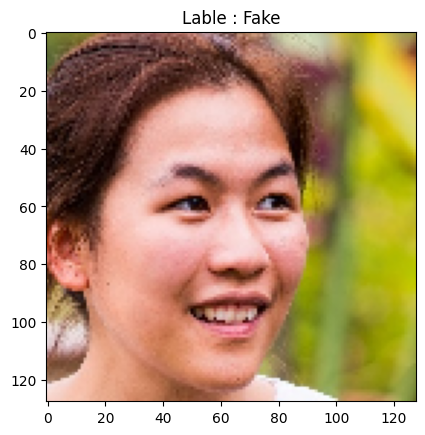

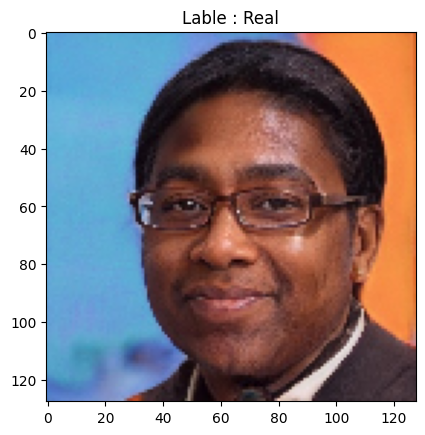

In [13]:
for images, labels in train_generator:
    for i in range(5):
      plt.imshow(images[i])
      plt.title(f"Lable : { 'Real' if labels[i]==0 else 'Fake'}")
      plt.show()

    break

In [14]:
history = model.fit(
    train_generator,
    validation_data=valid_gen,
    epochs=5,
    steps_per_epoch = train_generator.samples // 32,
    validation_steps = valid_gen.samples // 32
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2890s 920ms/step - accuracy: 0.4982 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2906s 930ms/step - accuracy: 0.4957 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 39us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2962s 930ms/step - accuracy: 0.5041 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932


Found 20000 images belonging to 2 classes.
625/625 ━━━━━━━━━━━━━━━━━━━━ 495s 779ms/step


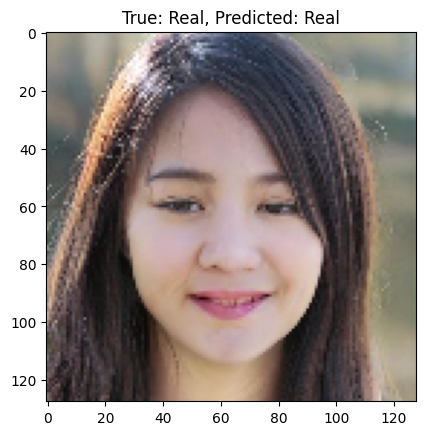

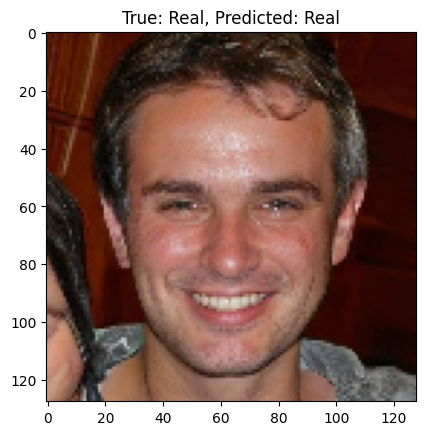

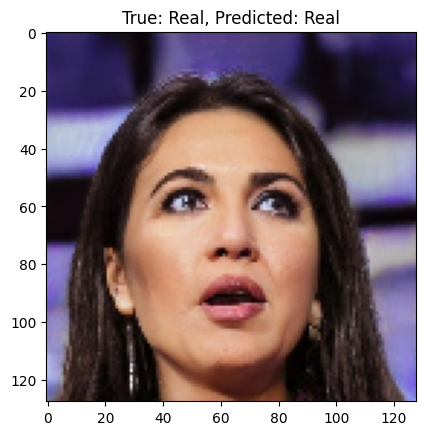

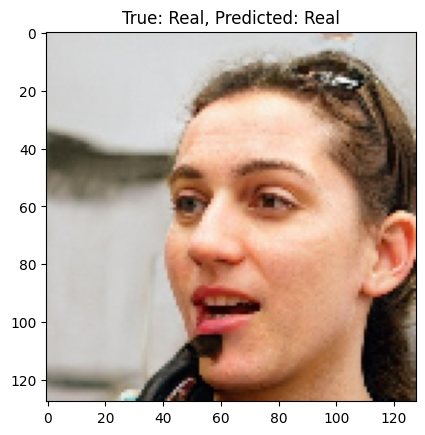

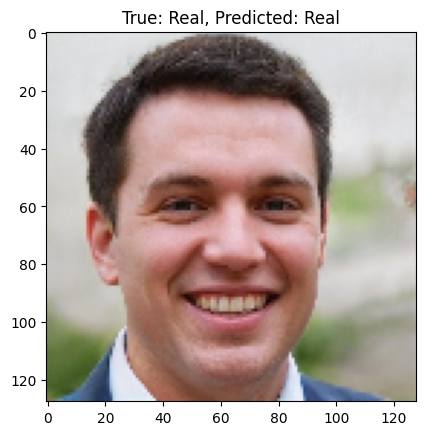

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10000
           1       0.00      0.00      0.00     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000

Confusion Matrix:
[[10000     0]
 [10000     0]]


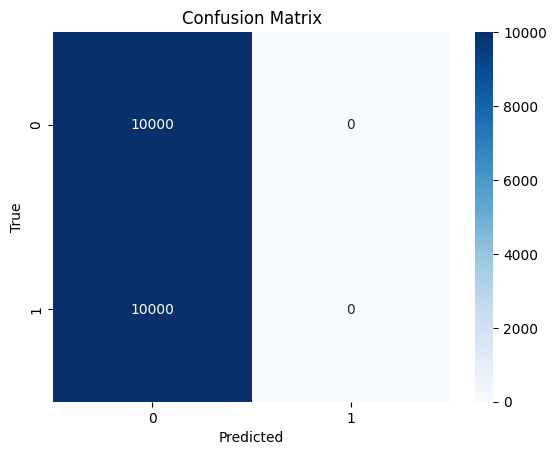

In [15]:
# prompt: how do i text my model top differentiate whether it si real or fake

import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code) ...

# After model training:
# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important: Do not shuffle for proper evaluation
)

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten() # Convert probabilities to class labels (0 or 1)

# Get true labels
true_classes = test_generator.classes


# Function to display images with predictions and true labels
def display_predictions(images, true_labels, predicted_labels):
  for i in range(len(images)):
    plt.imshow(images[i])
    plt.title(f"True: {'Real' if true_labels[i]==0 else 'Fake'}, Predicted: {'Real' if predicted_labels[i]==0 else 'Fake'}")
    plt.show()


# Get a batch of test images and their corresponding predictions
images, true_labels = next(test_generator)
#Display the first 5 images with their predictions
display_predictions(images[:5], true_labels[:5], predicted_classes[:5])

# Analyze the results (optional)
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(true_classes, predicted_classes))
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Plotting the Confusion Matrix (optional)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()